In [1]:
import os
os.environ["OMP_NUM_THREADS"] = str(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import extended_model as em
import synthetic_data_generation as sdg
import normalization as norm
from matplotlib import cm
import pickle

In [2]:
def calculate_mix(m_tensor,sv_pqn,lb,ub,timepoints,n_metabolites,n_cpu,n_replicates,loss_name,lambda_):
    '''
    Calculate normalization factor according to a MIX model.
    -
    m_tensor         numpy.ndarray of shape (n_metabolites * n_timepoints) of measured data.
    sv_pqn           numpy.ndarray of shape (n_timepoints) of normalization factors as calculated from PQN.
    lb               numpy.ndarray of shape (n_metabolites * 5 + n_timepoints) of lower bounds of parameters for model fitting.
    ub               numpy.ndarray of shape (n_metabolites * 5 + n_timepoints) of upper bounds of parameters for model fitting.
    timepoints       numpy.ndarray of shape (n_timepoints) of time points.
    n_metabolites    Int. Number of metabolites to fit. 
    n_cpu            Int. Number of CPUs used in multiprocessing.
    n_replicates     Int. Number of Monte Carlo replicates used for optimization.
    loss_name        Str. Loss used for optimization.
    -
    Output:
    sweat_volumes    numpy.ndarray of shape (n_timepoints) with normalization factors.
    model            Optimized em.MIX_model.
    '''
    
    # creating model and setting properties
    model = em.MIX_model(timepoints,n_metabolites,scale_fun='standard',pkm_fun='bateman',trans_fun='log10')
    # as the MIX model has one additional parameter the bounds have to be appended.
    model.set_fit_bounds(lb,ub)
    model.set_measured_data(m_tensor.flatten('F'),sv_pqn)
    model.set_loss_function(loss_name)
    pkm_sigma = np.ones(len(timepoints)*n_metabolites)*1/lambda_
    pqn_sigma = np.ones(len(timepoints))*1/(1-lambda_)
    model.set_sigma(np.concatenate([pkm_sigma,pqn_sigma]))
    # optimization of the model
    # out is a nd.array of shape ((n_parameters + 1) * n_replicates) with optimized parameters + loss value for every MC replicate.
    # as we are only interested in the best solution out is not used further.
    out = model.optimize_monte_carlo(n_replicates=n_replicates,n_cpu=n_cpu)
    return model.get_sweat_volumes(), model

In [3]:
def fn_to_nn(fn):
    '''
    Fraction of noisy datapoints to number of noisy metabolites. Number of non-noisy metabolites is 100.
    '''
    nn = 100*fn/(1-fn)
    # has to be int-ed for further processing
    return nn.astype(int)

def nn_to_fn(nn):
    '''
    Number of noisy metabolites fraction of noisy datapoints.. Number of non-noisy metabolites is 100.
    '''
    fn = nn/(100+nn)
    # has to be int-ed for further processing
    return fn

# Var(V_sweat) ~ Lambda

## Generate Synthetic Data

In [4]:
# define basic toy model parameters
toy_parameters = np.array([[2,.1,1,0,.1],
                            [2,.1,2,0,.1],
                            [2,.1,3,0,.1],
                            [2,.1,.5,0,.1]])
# define time points of toy model
timepoints = np.linspace(0,15,20)
# set seed of rng
np.random.seed(13)

## BEGIN INPUT PARAMETERS ##
bounds_per_metabolite  = [3,3,5,15,3]
noise_levels = fn_to_nn(np.array([0,.4,.8,.95]))
for error_sigma in [.2]:
    for n_metabolites in [100]:
        print('error sigma  ',error_sigma)
        print('n_metabolites',n_metabolites)
        n_replicates        = 100
        n_timepoints        = len(timepoints)
        n_known_metabolites = 4
        n_cpu               = 40
        n_mc_replicates     = 100
        loss_name           = 'cauchy_loss'
        ## END INPUT PARAMETERS ##

        # sample sv and e
        sv_t_list, sv_v_list = sdg.generate_sweat_volumes(n_replicates,n_metabolites,n_timepoints)
        e_list               = sdg.generate_experimental_errors(n_replicates,n_metabolites,n_timepoints,error_sigma)

        lambda_vals = [.99,.8,.5,.2,0]
        results_sv    = {}
        results_model = {}
        raw_values    = {'C':[],'SV':[],'M':[]}
        
            
        for lambda_ in lambda_vals:
            results_sv[lambda_] = {}
            results_model[lambda_] = {}
            for n_noise in noise_levels:
                results_sv[lambda_][n_noise] = []
                results_model[lambda_][n_noise] = []
            
        
        for n_replicate in range(n_replicates):
            print('n_replicate',n_replicate)

            ## DATA GENERATION
            sv_tensor = sv_t_list[n_replicate]
            sv_vector = sv_v_list[n_replicate]
            e_tensor  = e_list[n_replicate]
            # get concentration values
            c_tensor = sdg.generate_random_from_real_data(n_known_metabolites,n_metabolites,toy_parameters,timepoints,bounds_per_metabolite)
            # calculate M_tilde
            m_tensor     = c_tensor * sv_tensor * e_tensor
            # scaling can be done for a faster convergence. Since over all time points is the same this does not affect normalization.
            if n_metabolites != n_known_metabolites:
                for i in range(4,n_metabolites):
                    m_tensor[i] = m_tensor[i]/np.max(m_tensor[i])
            
            for n_noise in noise_levels:
                if n_noise == 0:
                    combined_tensor = m_tensor
                else:
                    noise_tensor = sdg.generate_random_from_real_data(4,n_noise+4,toy_parameters,timepoints,'unused')[4:,:]
                    combined_tensor = np.vstack([m_tensor,noise_tensor])
            
            

                ## CREATE BOUNDS FOR THE MODEL
                # mini model
                mini_lb = np.concatenate((np.zeros(5*n_known_metabolites),np.ones(n_timepoints)*.05))
                mini_ub = np.concatenate((bounds_per_metabolite*n_known_metabolites,np.ones(n_timepoints)*4))
                # the bounds for known parameteres are set to the true values + precision of the optimization function.
                for p in [2,3,4]:
                    mini_lb[:n_known_metabolites*5][p::5] = toy_parameters[:,p]
                    mini_ub[:n_known_metabolites*5][p::5] = toy_parameters[:,p]+10e-8

                ## NORMALIZE FOR SWEAT VOLUME
                sv_pqn                      = norm.calculate_pqn(combined_tensor)
                for lambda_ in lambda_vals:
                    sv_mix_mini, mix_mini_model = calculate_mix(combined_tensor[:4,:],sv_pqn,
                                                                mini_lb,mini_ub,timepoints,n_known_metabolites,
                                                                n_cpu,n_mc_replicates,loss_name,lambda_)
                    results_sv[lambda_][n_noise].append(sv_mix_mini)
                    results_model[lambda_][n_noise].append(mix_mini_model)

            raw_values['C'].append(c_tensor)
            raw_values['SV'].append(sv_vector)
            raw_values['M'].append(m_tensor)
print('done')              

error sigma   0.2
n_metabolites 100
n_replicate 0


100%|██████████| 100/100 [00:02<00:00, 36.67it/s]
/home/users/mgotsmy/envs/robust_loss/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 100/100 [00:01<00:00, 60.62it/s]


n_replicate 1


100%|██████████| 100/100 [00:01<00:00, 99.11it/s]


n_replicate 2


100%|██████████| 100/100 [00:00<00:00, 167.18it/s]


n_replicate 3


100%|██████████| 100/100 [00:00<00:00, 192.61it/s]


n_replicate 4


100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


n_replicate 5


100%|██████████| 100/100 [00:00<00:00, 213.53it/s]


n_replicate 6


100%|██████████| 100/100 [00:01<00:00, 57.12it/s]


n_replicate 7


100%|██████████| 100/100 [00:00<00:00, 214.83it/s]


n_replicate 8


100%|██████████| 100/100 [00:00<00:00, 157.85it/s]


n_replicate 9


100%|██████████| 100/100 [00:00<00:00, 216.35it/s]


n_replicate 10


100%|██████████| 100/100 [00:00<00:00, 135.23it/s]


n_replicate 11


100%|██████████| 100/100 [00:01<00:00, 51.89it/s]


n_replicate 12


100%|██████████| 100/100 [00:00<00:00, 101.41it/s]


n_replicate 13


100%|██████████| 100/100 [00:00<00:00, 152.58it/s]


n_replicate 14


100%|██████████| 100/100 [00:00<00:00, 219.55it/s]


n_replicate 15


100%|██████████| 100/100 [00:00<00:00, 194.95it/s]


n_replicate 16


100%|██████████| 100/100 [00:00<00:00, 170.74it/s]


n_replicate 17


100%|██████████| 100/100 [00:01<00:00, 82.20it/s]


n_replicate 18


100%|██████████| 100/100 [00:00<00:00, 182.11it/s]


n_replicate 19


100%|██████████| 100/100 [00:00<00:00, 194.06it/s]


n_replicate 20


100%|██████████| 100/100 [00:00<00:00, 113.75it/s]


n_replicate 21


100%|██████████| 100/100 [00:04<00:00, 22.55it/s]


n_replicate 22


100%|██████████| 100/100 [00:00<00:00, 134.80it/s]


n_replicate 23


100%|██████████| 100/100 [00:00<00:00, 196.19it/s]


n_replicate 24


100%|██████████| 100/100 [00:00<00:00, 128.33it/s]


n_replicate 25


100%|██████████| 100/100 [00:00<00:00, 144.74it/s]


n_replicate 26


100%|██████████| 100/100 [00:01<00:00, 61.10it/s]


n_replicate 27


100%|██████████| 100/100 [00:00<00:00, 138.07it/s]


n_replicate 28


100%|██████████| 100/100 [00:00<00:00, 152.35it/s]


n_replicate 29


100%|██████████| 100/100 [00:00<00:00, 211.94it/s]


n_replicate 30


100%|██████████| 100/100 [00:00<00:00, 155.62it/s]


n_replicate 31


100%|██████████| 100/100 [00:00<00:00, 163.04it/s]


n_replicate 32


100%|██████████| 100/100 [00:01<00:00, 72.64it/s]


n_replicate 33


100%|██████████| 100/100 [00:01<00:00, 53.37it/s]


n_replicate 34


100%|██████████| 100/100 [00:02<00:00, 47.48it/s]


n_replicate 35


100%|██████████| 100/100 [00:01<00:00, 84.64it/s]


n_replicate 36


100%|██████████| 100/100 [00:04<00:00, 21.74it/s]


n_replicate 37


100%|██████████| 100/100 [00:02<00:00, 49.81it/s]


n_replicate 38


100%|██████████| 100/100 [00:01<00:00, 53.23it/s]


n_replicate 39


100%|██████████| 100/100 [00:01<00:00, 85.23it/s]


n_replicate 40


100%|██████████| 100/100 [00:01<00:00, 77.27it/s]


n_replicate 41


100%|██████████| 100/100 [00:00<00:00, 214.40it/s]


n_replicate 42


100%|██████████| 100/100 [00:00<00:00, 138.40it/s]


n_replicate 43


100%|██████████| 100/100 [00:00<00:00, 102.00it/s]


n_replicate 44


100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


n_replicate 45


100%|██████████| 100/100 [00:01<00:00, 89.41it/s]


n_replicate 46


100%|██████████| 100/100 [00:00<00:00, 207.53it/s]


n_replicate 47


100%|██████████| 100/100 [00:00<00:00, 120.95it/s]


n_replicate 48


100%|██████████| 100/100 [00:00<00:00, 188.89it/s]


n_replicate 49


100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


n_replicate 50


100%|██████████| 100/100 [00:01<00:00, 86.96it/s]


n_replicate 51


100%|██████████| 100/100 [00:02<00:00, 41.78it/s]


n_replicate 52


100%|██████████| 100/100 [00:00<00:00, 135.47it/s]


n_replicate 53


100%|██████████| 100/100 [00:01<00:00, 63.52it/s]


n_replicate 54


100%|██████████| 100/100 [00:00<00:00, 101.78it/s]


n_replicate 55


100%|██████████| 100/100 [00:01<00:00, 99.39it/s]


n_replicate 56


100%|██████████| 100/100 [00:01<00:00, 84.03it/s]


n_replicate 57


100%|██████████| 100/100 [00:00<00:00, 151.55it/s]


n_replicate 58


100%|██████████| 100/100 [00:00<00:00, 116.52it/s]


n_replicate 59


100%|██████████| 100/100 [00:02<00:00, 35.23it/s]


n_replicate 60


100%|██████████| 100/100 [00:00<00:00, 171.71it/s]


n_replicate 61


100%|██████████| 100/100 [00:01<00:00, 78.24it/s]


n_replicate 62


100%|██████████| 100/100 [00:01<00:00, 52.12it/s]


n_replicate 63


100%|██████████| 100/100 [00:00<00:00, 141.26it/s]


n_replicate 64


100%|██████████| 100/100 [00:00<00:00, 103.41it/s]


n_replicate 65


100%|██████████| 100/100 [00:00<00:00, 151.80it/s]


n_replicate 66


100%|██████████| 100/100 [00:00<00:00, 150.09it/s]


n_replicate 67


100%|██████████| 100/100 [00:00<00:00, 204.71it/s]


n_replicate 68


100%|██████████| 100/100 [00:00<00:00, 129.32it/s]


n_replicate 69


100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


n_replicate 70


100%|██████████| 100/100 [00:00<00:00, 171.55it/s]


n_replicate 71


100%|██████████| 100/100 [00:01<00:00, 66.29it/s]


n_replicate 72


100%|██████████| 100/100 [00:00<00:00, 141.17it/s]


n_replicate 73


100%|██████████| 100/100 [00:00<00:00, 171.05it/s]


n_replicate 74


100%|██████████| 100/100 [00:00<00:00, 176.57it/s]


n_replicate 75


100%|██████████| 100/100 [00:00<00:00, 108.20it/s]


n_replicate 76


100%|██████████| 100/100 [00:01<00:00, 88.05it/s]


n_replicate 77


100%|██████████| 100/100 [00:00<00:00, 133.42it/s]


n_replicate 78


100%|██████████| 100/100 [00:02<00:00, 44.02it/s]


n_replicate 79


100%|██████████| 100/100 [00:00<00:00, 167.85it/s]


n_replicate 80


100%|██████████| 100/100 [00:00<00:00, 139.27it/s]


n_replicate 81


100%|██████████| 100/100 [00:01<00:00, 96.21it/s]


n_replicate 82


100%|██████████| 100/100 [00:00<00:00, 178.75it/s]


n_replicate 83


100%|██████████| 100/100 [00:00<00:00, 164.29it/s]


n_replicate 84


100%|██████████| 100/100 [00:00<00:00, 161.27it/s]


n_replicate 85


100%|██████████| 100/100 [00:01<00:00, 66.91it/s]


n_replicate 86


100%|██████████| 100/100 [00:00<00:00, 180.02it/s]


n_replicate 87


100%|██████████| 100/100 [00:03<00:00, 29.97it/s]


n_replicate 88


100%|██████████| 100/100 [00:01<00:00, 76.39it/s]


n_replicate 89


100%|██████████| 100/100 [00:01<00:00, 72.30it/s]


n_replicate 90


100%|██████████| 100/100 [00:01<00:00, 78.68it/s]


n_replicate 91


100%|██████████| 100/100 [00:00<00:00, 182.75it/s]


n_replicate 92


100%|██████████| 100/100 [00:00<00:00, 183.40it/s]


n_replicate 93


100%|██████████| 100/100 [00:01<00:00, 56.05it/s]


n_replicate 94


100%|██████████| 100/100 [00:01<00:00, 79.50it/s]


n_replicate 95


100%|██████████| 100/100 [00:01<00:00, 96.51it/s]


n_replicate 96


100%|██████████| 100/100 [00:00<00:00, 182.42it/s]


n_replicate 97


100%|██████████| 100/100 [00:00<00:00, 146.89it/s]


n_replicate 98


100%|██████████| 100/100 [00:01<00:00, 75.11it/s]


n_replicate 99


100%|██████████| 100/100 [00:00<00:00, 160.66it/s]


done


In [5]:
to_file = results_sv, results_model, raw_values
with open(f'other_results/lambda_variance.pkl','wb') as file:
    pickle.dump(to_file,file)

## Plot Figure

In [6]:
# with open(f'other_results/lambda_variance.pkl','rb') as file:
#     results_sv, results_model, raw_values = pickle.load(file)
# noise_levels = results_model[0].keys()
# lambda_vals = results_model.keys()

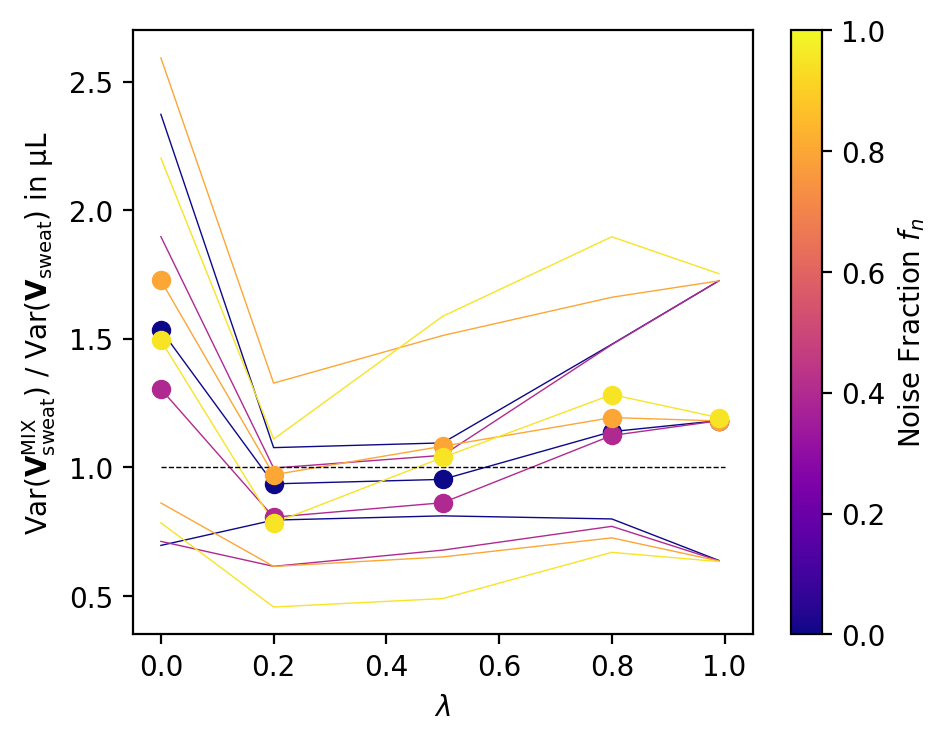

In [7]:
plt.figure(dpi=200,figsize=(5,4))
raw_vars = np.array([np.var(i) for i in raw_values['SV']])
for n_noise in noise_levels:
    means = []
    sds = []
    for lambda_ in lambda_vals:
        tmp_vars = []
        for idx, tmp_sv in enumerate(results_sv[lambda_][n_noise]):
            tmp_vars.append(np.var(tmp_sv)/raw_vars[idx])
#         plt.errorbar(lambda_,np.mean(tmp_vars),yerr=np.std(tmp_vars),color='grey',linewidth=.5,capsize=1,capthick=.5)
        plt.scatter(lambda_,np.mean(tmp_vars),color=cm.plasma(nn_to_fn(n_noise)),zorder=10)
        means.append(np.mean(tmp_vars))
        sds.append(np.std(tmp_vars))
    means = np.array(means)
    sds = np.array(sds)
    plt.plot(lambda_vals,means,    color=cm.plasma(nn_to_fn(n_noise)),linewidth=.5)
    plt.plot(lambda_vals,means+sds,color=cm.plasma(nn_to_fn(n_noise)),linewidth=.5)
    plt.plot(lambda_vals,means-sds,color=cm.plasma(nn_to_fn(n_noise)),linewidth=.5)
plt.plot([0,1],[1,1],'k--',linewidth=.5)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Var$(\mathbf{V}_{\rm sweat}^{\rm MIX})~/~\rm Var(\mathbf{V}_{\rm sweat})$ in µL')
plt.colorbar(mappable=cm.ScalarMappable(cmap='plasma'),label=r'Noise Fraction $f_n$')
plt.show()

# Independent PKM/PQN

## Generate Synthetic Data

In [8]:
# define basic toy model parameters
toy_parameters = np.array([[2,.1,1,0,.1],
                            [2,.1,2,0,.1],
                            [2,.1,3,0,.1],
                            [2,.1,.5,0,.1]])
# define time points of toy model
timepoints = np.linspace(0,15,20)
# set seed of rng
np.random.seed(13)

## BEGIN INPUT PARAMETERS ##
bounds_per_metabolite  = [3,3,5,15,3]
noise_levels = fn_to_nn(np.array([0,.5]))
for error_sigma in [.2]:
    for n_metabolites in [100]:
        n_replicates        = 100
        n_timepoints        = len(timepoints)
        n_known_metabolites = 4
        n_cpu               = 40
        n_mc_replicates     = 100
        loss_name           = 'cauchy_loss'
        ## END INPUT PARAMETERS ##

        # sample sv and e
        sv_t_list1, sv_v_list1 = sdg.generate_sweat_volumes(n_replicates,n_metabolites,n_timepoints)
        sv_t_list2, sv_v_list2 = sdg.generate_sweat_volumes(n_replicates,n_metabolites,n_timepoints)
        e_list                 = sdg.generate_experimental_errors(n_replicates,n_metabolites,n_timepoints,error_sigma)

        lambda_vals = [.99,.8,.5,.2,0]
        results_sv    = {}
        results_model = {}
        raw_values    = {'C':[],'SV1':[],'SV2':[],'M1':[],'M2':[]}
        
            
        for lambda_ in lambda_vals:
            results_sv[lambda_] = {}
            results_model[lambda_] = {}
            for n_noise in noise_levels:
                results_sv[lambda_][n_noise] = []
                results_model[lambda_][n_noise] = []
            
        
        for n_replicate in range(n_replicates):
            ## DATA GENERATION
            sv_tensor1 = sv_t_list1[n_replicate]
            sv_vector1 = sv_v_list1[n_replicate]
            sv_tensor2 = sv_t_list2[n_replicate]
            sv_vector2 = sv_v_list2[n_replicate]
            e_tensor   = e_list[n_replicate]
            # get concentration values
            c_tensor = sdg.generate_random_from_real_data(n_known_metabolites,n_metabolites,toy_parameters,timepoints,bounds_per_metabolite)
            # calculate M_tilde
            m_tensor1     = c_tensor * sv_tensor1 * e_tensor
            m_tensor2     = c_tensor * sv_tensor2 * e_tensor
            # scaling can be done for a faster convergence. Since over all time points is the same this does not affect normalization.
            if n_metabolites != n_known_metabolites:
                for i in range(4,n_metabolites):
                    m_tensor1[i] = m_tensor1[i]/np.max(m_tensor1[i])
                    m_tensor2[i] = m_tensor2[i]/np.max(m_tensor2[i])
            
            for n_noise in noise_levels:
                if n_noise == 0:
                    combined_tensor1 = m_tensor1
                    combined_tensor2 = m_tensor2
                else:
                    noise_tensor = sdg.generate_random_from_real_data(4,n_noise+4,toy_parameters,timepoints,'unused')[4:,:]
                    combined_tensor1 = np.vstack([m_tensor1,noise_tensor])
                    combined_tensor2 = np.vstack([m_tensor2,noise_tensor])

                ## CREATE BOUNDS FOR THE MODEL
                # mini model
                mini_lb = np.concatenate((np.zeros(5*n_known_metabolites),np.ones(n_timepoints)*.05))
                mini_ub = np.concatenate((bounds_per_metabolite*n_known_metabolites,np.ones(n_timepoints)*4))
                # the bounds for known parameteres are set to the true values + precision of the optimization function.
                for p in [2,3,4]:
                    mini_lb[:n_known_metabolites*5][p::5] = toy_parameters[:,p]
                    mini_ub[:n_known_metabolites*5][p::5] = toy_parameters[:,p]+10e-8

                ## NORMALIZE FOR SWEAT VOLUME
                sv_pqn                      = norm.calculate_pqn(combined_tensor1)
                for lambda_ in lambda_vals:
                    sv_mix_mini, mix_mini_model = calculate_mix(combined_tensor2[:4,:],sv_pqn,
                                                                mini_lb,mini_ub,timepoints,n_known_metabolites,
                                                                n_cpu,n_mc_replicates,loss_name,lambda_)
                    results_sv[lambda_][n_noise].append(sv_mix_mini)
                    results_model[lambda_][n_noise].append(mix_mini_model)

            raw_values['C'].append(c_tensor)
            raw_values['SV1'].append(sv_vector1)
            raw_values['SV2'].append(sv_vector2)
            raw_values['M1'].append(m_tensor1)
            raw_values['M2'].append(m_tensor2)
print('done')              

100%|██████████| 100/100 [00:00<00:00, 130.56it/s]
/home/users/mgotsmy/envs/robust_loss/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 100/100 [00:01<00:00, 88.46it/s]

done


In [9]:
# to_file = results_sv, results_model, raw_values
# with open(f'other_results/lambda_variance_indep.pkl','wb') as file:
#     pickle.dump(to_file,file)

## Plot Figure

In [16]:
with open(f'other_results/lambda_variance_indep.pkl','rb') as file:
    results_sv, results_model, raw_values = pickle.load(file)
noise_levels = results_model[0].keys()
lambda_vals = results_model.keys()
n_replicates = len(results_sv[0][0])

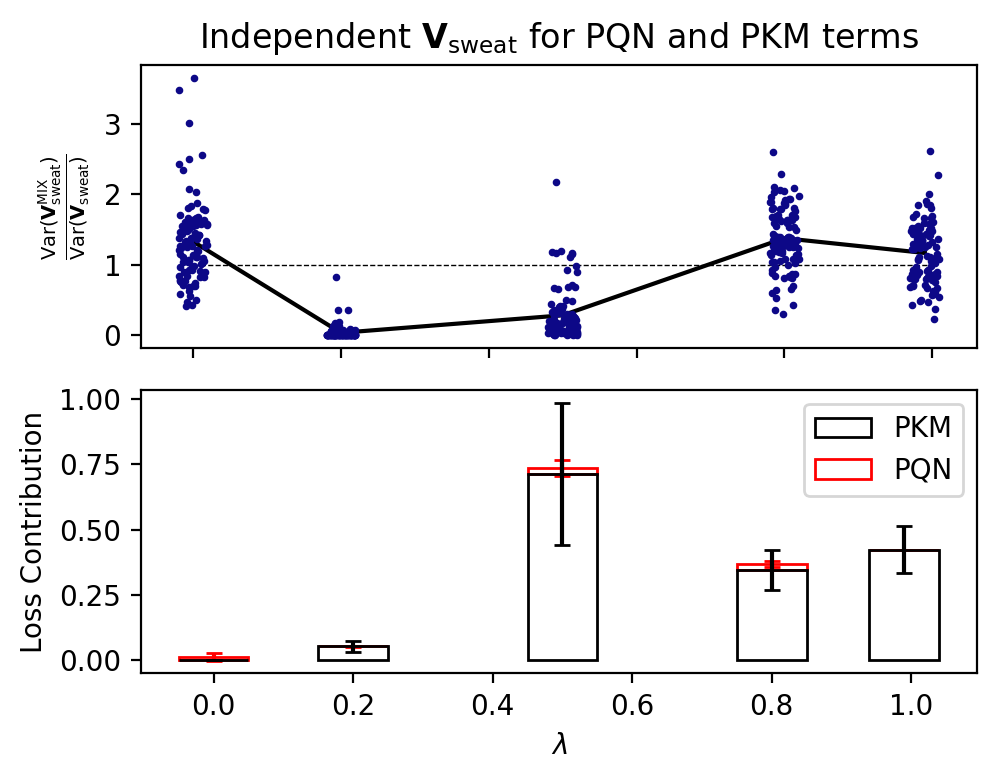

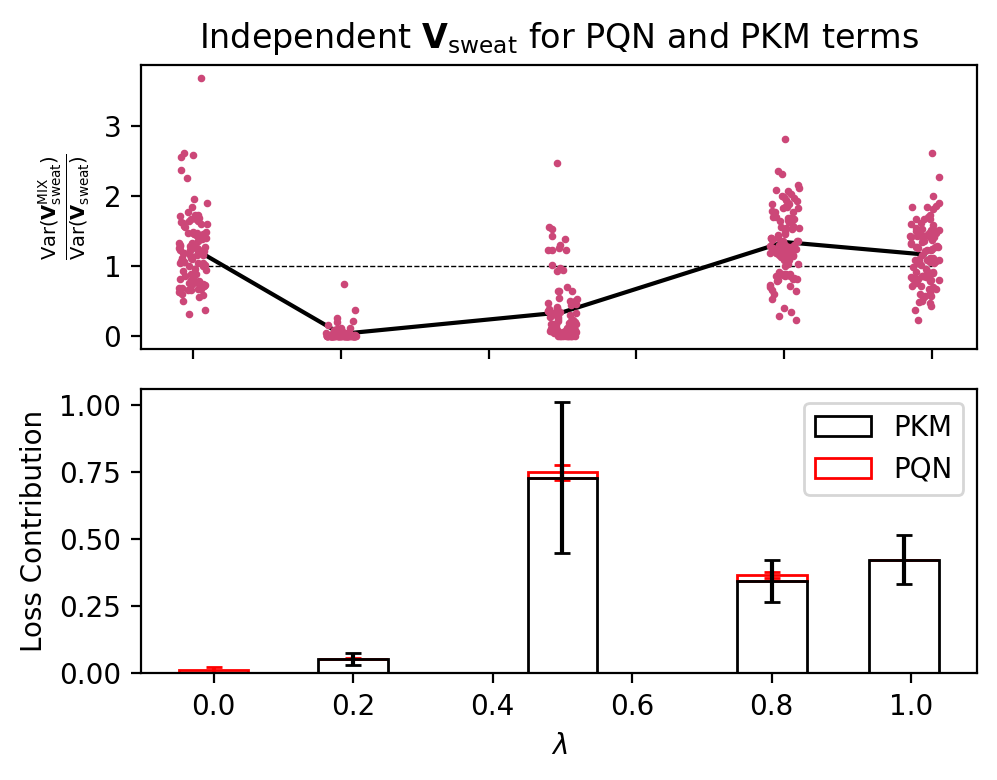

In [18]:
raw_vars = np.array([np.var(np.concatenate([raw_values['SV1'][i],raw_values['SV2'][i]])) for i in range(len(raw_values['SV1']))])
for n_noise in noise_levels:
    plt.figure(dpi=200,figsize=(5,4))
    
    # SUBPLOT 1
    ax1 = plt.subplot(211)
    plt.title(r'Independent $\mathbf{V}_{\rm sweat}$ for PQN and PKM terms')

    means = []
    for lambda_ in lambda_vals:
        tmp_vars = []
        for idx,tmp_sv in enumerate(results_sv[lambda_][n_noise]):
            tmp_vars.append(np.var(tmp_sv)/raw_vars[idx])
        plt.scatter(np.ones(len(tmp_vars))*lambda_+np.random.uniform(-.02,.02,len(tmp_vars)),tmp_vars,color=cm.plasma(nn_to_fn(n_noise)),zorder=10,s=3)
        means.append(np.mean(tmp_vars))
    plt.plot(lambda_vals,means,color='k')
    plt.plot([0,1],[1,1],'k--',linewidth=.5)
    plt.ylabel(r'$\frac{\rm Var(\mathbf{V}_{\rm sweat}^{\rm MIX})}{\rm Var(\mathbf{V}_{\rm sweat})}$')
    ax1.set_xticklabels([])

    # SUBPLOT 2
    plt.subplot(212)
    width = .1
    for lambda_ in lambda_vals:
        pkm_loss = []
        pqn_loss = []
        for n_replicate in range(n_replicates):
            m = results_model[lambda_][n_noise][n_replicate]
            loss = m.rho[0]
            tmp_pkm_loss = np.sum(loss[:m.n_timepoints*m.n_metabolites])*lambda_
            tmp_pqn_loss = np.sum(loss[m.n_timepoints*m.n_metabolites:])*(1-lambda_)
            tmp_loss = tmp_pkm_loss+tmp_pqn_loss
            pkm_loss.append(tmp_pkm_loss)#/tmp_loss)
            pqn_loss.append(tmp_pqn_loss)#/tmp_loss)
        bar1 = plt.bar(lambda_,np.mean(pkm_loss),edgecolor='k',width=width,fill=False,zorder=1,label='PKM')
        plt.errorbar(lambda_,np.mean(pkm_loss),yerr=np.std(pkm_loss),color='k',capsize=3,zorder=1)
        bar2 = plt.bar(lambda_,np.mean(pqn_loss),edgecolor='r',width=width,bottom=np.mean(pkm_loss),fill=False,zorder=0,label='PQN')
        plt.errorbar(lambda_,np.mean(pqn_loss)+np.mean(pkm_loss),yerr=np.std(pqn_loss),color='r',capsize=3,zorder=0)
    plt.xlabel(r'$\lambda$')
    plt.ylabel('Loss Contribution')
    plt.legend(handles=[bar1,bar2])

    plt.tight_layout()
    plt.show()

# Dependent PKM/PQN

## Generate Synthetic Data

In [12]:
# define basic toy model parameters
toy_parameters = np.array([[2,.1,1,0,.1],
                            [2,.1,2,0,.1],
                            [2,.1,3,0,.1],
                            [2,.1,.5,0,.1]])
# define time points of toy model
timepoints = np.linspace(0,15,20)
# set seed of rng
np.random.seed(13)

## BEGIN INPUT PARAMETERS ##
bounds_per_metabolite  = [3,3,5,15,3]
noise_levels = fn_to_nn(np.array([0,.5]))
for error_sigma in [.2]:
    for n_metabolites in [100]:
        n_replicates        = 100
        n_timepoints        = len(timepoints)
        n_known_metabolites = 4
        n_cpu               = 40
        n_mc_replicates     = 100
        loss_name           = 'cauchy_loss'
        ## END INPUT PARAMETERS ##

        # sample sv and e
        sv_t_list1, sv_v_list1 = sdg.generate_sweat_volumes(n_replicates,n_metabolites,n_timepoints)
        e_list                 = sdg.generate_experimental_errors(n_replicates,n_metabolites,n_timepoints,error_sigma)

        lambda_vals = [.99,.8,.5,.2,0]
        results_sv    = {}
        results_model = {}
        raw_values    = {'C':[],'SV1':[],'M1':[]}
        
            
        for lambda_ in lambda_vals:
            results_sv[lambda_] = {}
            results_model[lambda_] = {}
            for n_noise in noise_levels:
                results_sv[lambda_][n_noise] = []
                results_model[lambda_][n_noise] = []
            
        
        for n_replicate in range(n_replicates):
            ## DATA GENERATION
            sv_tensor1 = sv_t_list1[n_replicate]
            sv_vector1 = sv_v_list1[n_replicate]
            e_tensor   = e_list[n_replicate]
            # get concentration values
            c_tensor = sdg.generate_random_from_real_data(n_known_metabolites,n_metabolites,toy_parameters,timepoints,bounds_per_metabolite)
            # calculate M_tilde
            m_tensor1     = c_tensor * sv_tensor1 * e_tensor
            # scaling can be done for a faster convergence. Since over all time points is the same this does not affect normalization.
            if n_metabolites != n_known_metabolites:
                for i in range(4,n_metabolites):
                    m_tensor1[i] = m_tensor1[i]/np.max(m_tensor1[i])
            
            for n_noise in noise_levels:
                if n_noise == 0:
                    combined_tensor1 = m_tensor1
                else:
                    noise_tensor = sdg.generate_random_from_real_data(4,n_noise+4,toy_parameters,timepoints,'unused')[4:,:]
                    combined_tensor1 = np.vstack([m_tensor1,noise_tensor])

                ## CREATE BOUNDS FOR THE MODEL
                # mini model
                mini_lb = np.concatenate((np.zeros(5*n_known_metabolites),np.ones(n_timepoints)*.05))
                mini_ub = np.concatenate((bounds_per_metabolite*n_known_metabolites,np.ones(n_timepoints)*4))
                # the bounds for known parameteres are set to the true values + precision of the optimization function.
                for p in [2,3,4]:
                    mini_lb[:n_known_metabolites*5][p::5] = toy_parameters[:,p]
                    mini_ub[:n_known_metabolites*5][p::5] = toy_parameters[:,p]+10e-8

                ## NORMALIZE FOR SWEAT VOLUME
                sv_pqn                      = norm.calculate_pqn(combined_tensor1)
                for lambda_ in lambda_vals:
                    sv_mix_mini, mix_mini_model = calculate_mix(combined_tensor1[:4,:],sv_pqn,
                                                                mini_lb,mini_ub,timepoints,n_known_metabolites,
                                                                n_cpu,n_mc_replicates,loss_name,lambda_)
                    results_sv[lambda_][n_noise].append(sv_mix_mini)
                    results_model[lambda_][n_noise].append(mix_mini_model)

            raw_values['C'].append(c_tensor)
            raw_values['SV1'].append(sv_vector1)
            raw_values['M1'].append(m_tensor1)
print('done')              

100%|██████████| 100/100 [00:09<00:00, 10.07it/s]
/home/users/mgotsmy/envs/robust_loss/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 100/100 [00:00<00:00, 166.91it/s]


done


In [19]:
# to_file = results_sv, results_model, raw_values
# with open(f'other_results/lambda_variance_dep.pkl','wb') as file:
#     pickle.dump(to_file,file)

## Plot Figure

In [20]:
with open(f'other_results/lambda_variance_dep.pkl','rb') as file:
    results_sv, results_model, raw_values = pickle.load(file)
noise_levels = results_model[0].keys()
lambda_vals = results_model.keys()

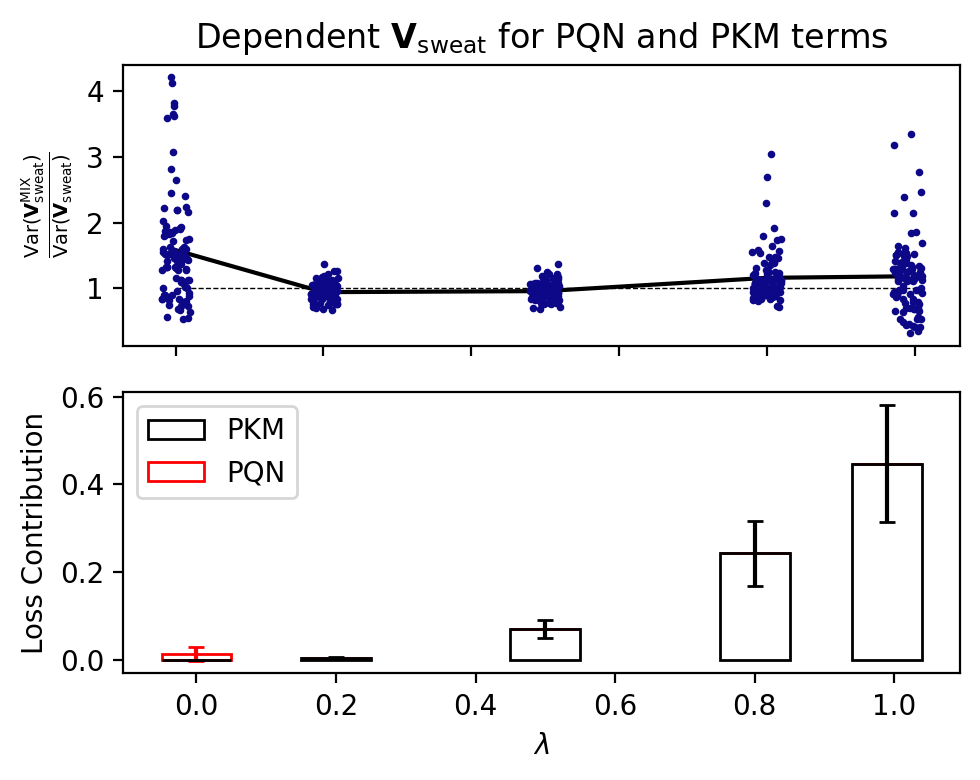

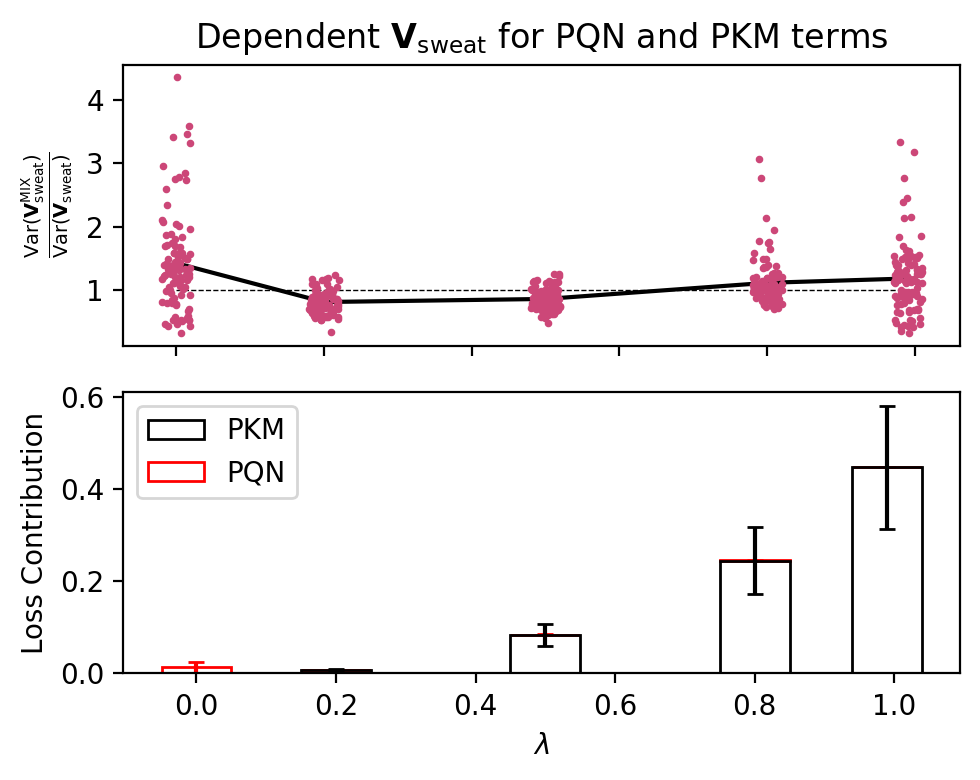

In [21]:
raw_vars = np.array([np.var(i) for i in raw_values['SV1']])
for n_noise in noise_levels:
    plt.figure(dpi=200,figsize=(5,4))
    
    # SUBPLOT 1
    ax1 = plt.subplot(211)
    plt.title(r'Dependent $\mathbf{V}_{\rm sweat}$ for PQN and PKM terms')
    means = []
    for lambda_ in lambda_vals:
        tmp_vars = []
        for idx,tmp_sv in enumerate(results_sv[lambda_][n_noise]):
            tmp_vars.append(np.var(tmp_sv)/raw_vars[idx])
        plt.scatter(np.ones(len(tmp_vars))*lambda_+np.random.uniform(-.02,.02,len(tmp_vars)),tmp_vars,color=cm.plasma(nn_to_fn(n_noise)),zorder=10,s=3)
        means.append(np.mean(tmp_vars))
    plt.plot(lambda_vals,means,color='k')
    plt.plot([0,1],[1,1],'k--',linewidth=.5)
    plt.ylabel(r'$\frac{\rm Var(\mathbf{V}_{\rm sweat}^{\rm MIX})}{\rm Var(\mathbf{V}_{\rm sweat})}$')
    ax1.set_xticklabels([])

    # SUBPLOT 2
    plt.subplot(212)
    width = .1
    for lambda_ in lambda_vals:
        pkm_loss = []
        pqn_loss = []
        for n_replicate in range(n_replicates):
            m = results_model[lambda_][n_noise][n_replicate]
            loss = m.rho[0]
            tmp_pkm_loss = np.sum(loss[:m.n_timepoints*m.n_metabolites])*lambda_
            tmp_pqn_loss = np.sum(loss[m.n_timepoints*m.n_metabolites:])*(1-lambda_)
            tmp_loss = tmp_pkm_loss+tmp_pqn_loss
            pkm_loss.append(tmp_pkm_loss)#/tmp_loss)
            pqn_loss.append(tmp_pqn_loss)#/tmp_loss)
        bar1 = plt.bar(lambda_,np.mean(pkm_loss),edgecolor='k',width=width,fill=False,zorder=1,label='PKM')
        plt.errorbar(lambda_,np.mean(pkm_loss),yerr=np.std(pkm_loss),color='k',capsize=3,zorder=1)
        bar2 = plt.bar(lambda_,np.mean(pqn_loss),edgecolor='r',width=width,bottom=np.mean(pkm_loss),fill=False,zorder=0,label='PQN')
        plt.errorbar(lambda_,np.mean(pqn_loss)+np.mean(pkm_loss),yerr=np.std(pqn_loss),color='r',capsize=3,zorder=0)
    plt.xlabel(r'$\lambda$')
    plt.ylabel('Loss Contribution')
    plt.legend(handles=[bar1,bar2])

    plt.tight_layout()
    plt.show()